# Load dataset into a tensor

Unlike the first iteration, this one will use hourly data and use the change of pricing. This should allow for the network to work at any price scale as before it was having trouble using the full range of pricing history. Additionally, I am using a sliding window that does not stride its entire length. This could potentially cause prediction power as it is mixing the labels into features, but there is not enough hourly data to sufficiently isolate it.

In [1]:
import csv
import numpy as np

OPEN_IDX = 2
HIGH_IDX = 3
LOW_IDX = 4
CLOSE_IDX = 1
VOLUME_IDX = 5
CHANGE_IDX = 6

FEATURES = 6
PRICE_INTERVAL = 240
STRIDE_INTERVAL = 1
print(f'PRICE : {PRICE_INTERVAL}\nSTRIDE: {STRIDE_INTERVAL}')

def volume_convert(volume):
    if volume == '-':
        return 0
    elif volume[-1] == 'M':
        return float(volume[:-1]) * 1000
    elif volume[-1] == 'B':
        return float(volume[:-1]) * 1000000
    else:
        return float(volume[:-1])

header_read = False

original_data = []
with open('datasets/eth_1day.csv', newline='') as csvfile:
    datareader = csv.reader(csvfile)
    for data in datareader:
        if header_read:
            original_data.append(np.array([
                float(data[OPEN_IDX].replace(',', '')),
                float(data[CLOSE_IDX].replace(',', '')),
                float(data[HIGH_IDX].replace(',', '')),
                float(data[LOW_IDX].replace(',', '')),
                volume_convert(data[VOLUME_IDX]),
                float(data[CHANGE_IDX][:-1])
            ]))
        else:
            header_read = True
original_data.reverse()
                                 
x_batch = []
x = []
y = []
for row in original_data:
    if len(x_batch) < PRICE_INTERVAL:
        x_batch.append(row)
    else:
        x.append(x_batch)
        y.append(row[0])
        x_batch = x_batch[STRIDE_INTERVAL:]
        x_batch.append(row)
            
x = np.array(x)
y = np.array(y)

permutation = np.random.permutation(x.shape[0])

x = x[permutation]
y = y[permutation]

PRICE : 240
STRIDE: 1


In [2]:
x.shape

(2441, 240, 6)

In [3]:
import torch

TRAIN_SPLIT = int(0.8 * x.shape[0])
VALIDATION_SPLIT = int(0.9 * x.shape[0])

train_dataset = {
    'x': torch.tensor(x[:TRAIN_SPLIT]).float().cuda(),
    'y': torch.tensor(y[:TRAIN_SPLIT]).float().cuda()
}
validation_dataset = {
    'x': torch.tensor(x[TRAIN_SPLIT:VALIDATION_SPLIT]).float().cuda(),
    'y': torch.tensor(y[TRAIN_SPLIT:VALIDATION_SPLIT]).float().cuda()
}
test_dataset = {
    'x': torch.tensor(x[VALIDATION_SPLIT:]).float().cuda(),
    'y': torch.tensor(y[VALIDATION_SPLIT:]).float().cuda()
}

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, num_of_features, model_dim, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1).repeat(1, num_of_features, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class EthModel(nn.Module):
    def __init__(self, num_of_features, num_of_layers, hidden_size, num_of_heads, seq_length, batch_size):
        super().__init__()
        
        self.pos_encoder = PositionalEncoding(num_of_features, seq_length)
        self.transformer = nn.Transformer(num_of_features, num_of_heads, num_of_layers, num_of_layers, hidden_size, batch_first=True)
#         encoder_layers = nn.TransformerEncoderLayer(num_of_features, num_of_heads, hidden_size, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_of_layers)
        self.seq_len = seq_length
#         decoder_layers = nn.TransformerDecoderLayer(num_of_features, num_of_heads, hidden_size, batch_first=True)
#         self.decoder = nn.TransformerDecoder(decoder_layers, num_of_layers)
        self.src_mask = None
        self.fc = nn.Linear(num_of_features, 1)
    
    def _generate_square_subsequence_mask(self, size):
        mask = (torch.triu(torch.ones(size, size))).transpose(0, 1)
        mask = mask.masked_fill(mask == 0, -1e9).masked_fill(mask == 1, float(0.0))
        return mask
        
    def forward(self, x, target, should_mask = True):
        if should_mask:
            if self.src_mask is None or self.src_mask.size(0) != x.shape[1]:
                self.src_mask = self._generate_square_subsequence_mask(x.shape[1]).cuda()
        else:
            self.src_mask = None
        
        x = self.pos_encoder(x.view(-1, x.shape[2], x.shape[1]))
        x = x.reshape(-1, x.shape[2], x.shape[1])
#         x = self.transformer_encoder(x, self.src_mask)
#         print(x.shape)
#         x = self.decoder(1, x)
        x = self.transformer(x, target, self.src_mask)
        x = self.fc(x)
        return x.squeeze()

In [5]:
import torch.optim as optim
import torch.utils.data as data

torch.set_printoptions(sci_mode=False)

BATCH_SIZE = 32
SEQUENCE_LENGTH = train_dataset['x'].shape[1]
RNN_LAYERS = 12

model = EthModel(FEATURES, RNN_LAYERS, 2048, 3, SEQUENCE_LENGTH, BATCH_SIZE).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_loader = data.DataLoader(data.TensorDataset(train_dataset['x'], train_dataset['y']),
                               shuffle=True, batch_size=BATCH_SIZE)
validation_loader = data.DataLoader(data.TensorDataset(validation_dataset['x'], validation_dataset['y']),
                                    shuffle=True, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(data.TensorDataset(test_dataset['x'], test_dataset['y']),
                                    shuffle=True, batch_size=BATCH_SIZE)

target = torch.ones(BATCH_SIZE, 1, FEATURES).cuda()
with torch.no_grad():
    batch_x, batch_y = next(iter(train_loader))
    output = model(batch_x, target)
print(batch_y.shape)
print(output)

torch.Size([32])
tensor([-0.7259,  0.4521, -0.9920,  0.6053,  0.7424, -0.9920,  0.9149,  0.3735,
         0.5628,  0.7455,  0.9429,  0.5680,  0.3081,  0.7999,  0.8883,  0.3365,
        -1.0914,  0.3507,  0.3397, -1.2075, -0.7519, -0.2889,  0.8144,  0.1016,
         0.5306,  0.3048,  0.9824,  0.6177,  0.9361,  0.4693,  0.9337, -0.2671],
       device='cuda:0')


In [6]:
import time

EPOCHS=500
best_validation = 1e9

start_train = time.time()
for epoch in range(EPOCHS):
    start_epoch = time.time()
    
    # Do a training pass for all batches.
    model.train()
    train_error = 0
    train_loss = 0
    train_total = 0
    for batch_x, batch_y in train_loader:
        target = torch.ones(batch_x.shape[0], 1, FEATURES).cuda()
        output = model(batch_x, target)
        loss = criterion(output, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        optimizer.step()
        
        train_loss += np.sqrt(loss.item())
        train_error += torch.sum(torch.abs(output - batch_y))
        train_total += batch_x.shape[0]
    
    # Compute the RMSE and total average error
    train_rmse = train_loss / train_total
    train_terr = train_error / train_total
    
    # Validate the model on a new set.
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        validation_error = 0
        validation_total = 0
        for batch_x, batch_y in validation_loader:
            target = torch.ones(batch_x.shape[0], 1, FEATURES).cuda()
            output = model(batch_x, target)
            validation_error += torch.sum(torch.abs(output - batch_y))
            validation_loss += np.sqrt(criterion(output, batch_y).item())
            validation_total += batch_x.shape[0]
    
    # Compute the RMSE and total average error
    validation_rmse = validation_loss / validation_total
    validation_terr = validation_error / validation_total

    # Save the model if its better than the last one
    if validation_loss < best_validation:
        torch.save(model.state_dict(), 'best.pt')
        best_validation = validation_loss
        print(f"New best: {validation_rmse:.4f}")
    
    # Show results of the epoch.
    print(f'| epoch {epoch} => ' +
          f'train RMSE: {train_rmse:.4f} | '+
          f'train error: {train_terr:.4f} | '+
          f'validation RMSE: {validation_rmse:.4f} | ' +
          f'validation error: {validation_terr:.4f} | ' +
          f'{(time.time() - start_epoch):.2f} sec |')

train_duration = time.time() - start_train
train_sec = train_duration % 60
train_minutes = (train_duration // 60) % 60
train_hours = train_duration // 3600
print(f"Total train time: {train_hours:.0f}hr {train_minutes:.0f}min {train_sec:.0f}sec")

New best: 51.1439
| epoch 0 => train RMSE: 46.7980 | train error: 1020.2249 | validation RMSE: 51.1439 | validation error: 1093.6210 | 8.73 sec |
New best: 50.4574
| epoch 1 => train RMSE: 46.7898 | train error: 1019.5832 | validation RMSE: 50.4574 | validation error: 1092.9395 | 8.38 sec |
| epoch 2 => train RMSE: 46.6685 | train error: 1018.8246 | validation RMSE: 51.1735 | validation error: 1092.1003 | 8.02 sec |
| epoch 3 => train RMSE: 46.6941 | train error: 1017.9096 | validation RMSE: 52.0814 | validation error: 1091.1100 | 8.05 sec |
| epoch 4 => train RMSE: 46.3276 | train error: 1016.8530 | validation RMSE: 51.7297 | validation error: 1089.9875 | 8.62 sec |
| epoch 5 => train RMSE: 46.5471 | train error: 1015.6722 | validation RMSE: 51.7234 | validation error: 1088.7484 | 8.69 sec |
| epoch 6 => train RMSE: 46.5708 | train error: 1014.3835 | validation RMSE: 51.9866 | validation error: 1087.4144 | 8.85 sec |
New best: 49.9898
| epoch 7 => train RMSE: 46.5665 | train error: 10

New best: 45.2968
| epoch 63 => train RMSE: 42.2608 | train error: 854.7181 | validation RMSE: 45.2968 | validation error: 918.9647 | 8.57 sec |
| epoch 64 => train RMSE: 41.9550 | train error: 852.4897 | validation RMSE: 46.6074 | validation error: 916.5530 | 8.46 sec |
New best: 45.2395
| epoch 65 => train RMSE: 41.9805 | train error: 850.3375 | validation RMSE: 45.2395 | validation error: 914.1334 | 8.43 sec |
| epoch 66 => train RMSE: 41.8822 | train error: 848.2896 | validation RMSE: 46.3643 | validation error: 911.8052 | 8.32 sec |
New best: 44.8179
| epoch 67 => train RMSE: 41.8151 | train error: 846.3956 | validation RMSE: 44.8179 | validation error: 909.5410 | 8.45 sec |
| epoch 68 => train RMSE: 41.7182 | train error: 844.5209 | validation RMSE: 45.9231 | validation error: 907.3073 | 8.39 sec |
| epoch 69 => train RMSE: 41.5124 | train error: 842.7331 | validation RMSE: 46.1786 | validation error: 905.2527 | 8.67 sec |
| epoch 70 => train RMSE: 41.5180 | train error: 841.0954

| epoch 126 => train RMSE: 34.9234 | train error: 872.4835 | validation RMSE: 38.4496 | validation error: 900.3634 | 8.42 sec |
| epoch 127 => train RMSE: 35.2035 | train error: 874.5278 | validation RMSE: 37.9671 | validation error: 901.2703 | 8.59 sec |
New best: 37.4548
| epoch 128 => train RMSE: 35.1213 | train error: 876.3944 | validation RMSE: 37.4548 | validation error: 902.1634 | 8.68 sec |
| epoch 129 => train RMSE: 35.0389 | train error: 878.0907 | validation RMSE: 38.3271 | validation error: 902.9983 | 8.51 sec |
| epoch 130 => train RMSE: 35.0708 | train error: 879.9495 | validation RMSE: 37.5662 | validation error: 904.0040 | 8.42 sec |
| epoch 131 => train RMSE: 34.9875 | train error: 881.3329 | validation RMSE: 37.6587 | validation error: 904.7939 | 8.44 sec |
| epoch 132 => train RMSE: 34.8003 | train error: 883.2186 | validation RMSE: 37.9072 | validation error: 905.7226 | 8.16 sec |
| epoch 133 => train RMSE: 34.8373 | train error: 884.9387 | validation RMSE: 37.8627 

| epoch 190 => train RMSE: 34.6044 | train error: 917.8129 | validation RMSE: 36.4056 | validation error: 926.5217 | 8.58 sec |
| epoch 191 => train RMSE: 34.5613 | train error: 918.0762 | validation RMSE: 37.0047 | validation error: 926.6248 | 8.58 sec |
| epoch 192 => train RMSE: 34.6513 | train error: 917.9067 | validation RMSE: 37.5551 | validation error: 926.5289 | 8.38 sec |
| epoch 193 => train RMSE: 34.5876 | train error: 918.3453 | validation RMSE: 36.4796 | validation error: 926.6927 | 8.49 sec |
| epoch 194 => train RMSE: 34.5754 | train error: 917.1613 | validation RMSE: 37.3764 | validation error: 926.1573 | 8.52 sec |
| epoch 195 => train RMSE: 34.5553 | train error: 916.9990 | validation RMSE: 36.4351 | validation error: 926.2749 | 8.28 sec |
| epoch 196 => train RMSE: 34.5463 | train error: 917.0623 | validation RMSE: 37.1876 | validation error: 926.6948 | 8.58 sec |
| epoch 197 => train RMSE: 34.6948 | train error: 916.9924 | validation RMSE: 37.4790 | validation error

| epoch 254 => train RMSE: 34.6952 | train error: 919.7740 | validation RMSE: 37.6859 | validation error: 927.4596 | 8.21 sec |
| epoch 255 => train RMSE: 34.6267 | train error: 918.9239 | validation RMSE: 37.1959 | validation error: 926.8704 | 8.32 sec |
| epoch 256 => train RMSE: 34.5232 | train error: 916.6948 | validation RMSE: 37.4951 | validation error: 926.3472 | 8.52 sec |
| epoch 257 => train RMSE: 34.5656 | train error: 919.4581 | validation RMSE: 36.3310 | validation error: 927.7050 | 8.49 sec |
| epoch 258 => train RMSE: 34.6553 | train error: 919.1309 | validation RMSE: 37.6030 | validation error: 927.2986 | 8.62 sec |
| epoch 259 => train RMSE: 34.4516 | train error: 919.5728 | validation RMSE: 36.7208 | validation error: 927.9605 | 8.60 sec |
| epoch 260 => train RMSE: 34.6439 | train error: 919.3120 | validation RMSE: 36.8577 | validation error: 927.2095 | 8.67 sec |
| epoch 261 => train RMSE: 34.6332 | train error: 920.0046 | validation RMSE: 37.1997 | validation error

| epoch 318 => train RMSE: 34.5167 | train error: 919.0096 | validation RMSE: 37.2617 | validation error: 928.8593 | 8.55 sec |
| epoch 319 => train RMSE: 34.5981 | train error: 920.6370 | validation RMSE: 37.3172 | validation error: 929.2118 | 8.42 sec |
| epoch 320 => train RMSE: 34.6829 | train error: 920.2665 | validation RMSE: 37.2735 | validation error: 929.2914 | 8.35 sec |
| epoch 321 => train RMSE: 34.6122 | train error: 921.3209 | validation RMSE: 37.1371 | validation error: 929.7562 | 8.58 sec |
| epoch 322 => train RMSE: 34.6279 | train error: 921.7580 | validation RMSE: 36.2930 | validation error: 929.8442 | 8.54 sec |
| epoch 323 => train RMSE: 34.5781 | train error: 921.4197 | validation RMSE: 36.6958 | validation error: 929.5656 | 8.55 sec |
| epoch 324 => train RMSE: 34.6228 | train error: 921.4094 | validation RMSE: 37.2204 | validation error: 929.6490 | 8.58 sec |
| epoch 325 => train RMSE: 34.4913 | train error: 921.1140 | validation RMSE: 37.2736 | validation error

| epoch 382 => train RMSE: 34.5728 | train error: 919.6485 | validation RMSE: 36.9991 | validation error: 929.4245 | 8.74 sec |
| epoch 383 => train RMSE: 34.6518 | train error: 921.0158 | validation RMSE: 37.2951 | validation error: 929.4426 | 8.45 sec |
| epoch 384 => train RMSE: 34.6828 | train error: 920.7449 | validation RMSE: 36.9824 | validation error: 929.2189 | 8.57 sec |
| epoch 385 => train RMSE: 34.4921 | train error: 919.5878 | validation RMSE: 36.3014 | validation error: 929.1991 | 8.62 sec |
| epoch 386 => train RMSE: 34.5028 | train error: 919.6414 | validation RMSE: 37.0556 | validation error: 929.0251 | 8.73 sec |
| epoch 387 => train RMSE: 34.6103 | train error: 920.4313 | validation RMSE: 37.1606 | validation error: 929.0974 | 8.46 sec |
| epoch 388 => train RMSE: 34.6398 | train error: 919.7825 | validation RMSE: 37.7559 | validation error: 928.9042 | 8.40 sec |
| epoch 389 => train RMSE: 34.6129 | train error: 919.3733 | validation RMSE: 37.1595 | validation error

| epoch 447 => train RMSE: 34.6378 | train error: 920.7664 | validation RMSE: 36.9414 | validation error: 929.2137 | 8.51 sec |
| epoch 448 => train RMSE: 34.5218 | train error: 920.3998 | validation RMSE: 37.5518 | validation error: 929.3293 | 8.70 sec |
| epoch 449 => train RMSE: 34.5755 | train error: 921.0685 | validation RMSE: 37.0411 | validation error: 929.6613 | 8.53 sec |
| epoch 450 => train RMSE: 34.6662 | train error: 920.3968 | validation RMSE: 37.4887 | validation error: 929.4295 | 8.37 sec |
| epoch 451 => train RMSE: 34.5665 | train error: 919.7332 | validation RMSE: 37.0607 | validation error: 929.5384 | 8.94 sec |
| epoch 452 => train RMSE: 34.5495 | train error: 919.6056 | validation RMSE: 37.3415 | validation error: 929.6307 | 8.45 sec |
| epoch 453 => train RMSE: 34.5201 | train error: 920.5584 | validation RMSE: 37.4671 | validation error: 929.2838 | 8.68 sec |
| epoch 454 => train RMSE: 34.5303 | train error: 920.2456 | validation RMSE: 36.8930 | validation error

# Results

All experiements were done over 500 epochs. Strongest validation model was picked and tested against a random test set.

> MCG-3 needs recompiled and saved.

| Trial | LR | RMSE | Error | Size | Train Time |
|:----|:---|:---|:--- |:---|:---|
| GRU Only | `0.001` |  `3.1324` | `67.4118` | `1.03 GB` | `00:48:07` |
| Conv+GRU (CoGr) | `0.001` | `3.1452` | `66.5887` | `521MB` | `00:22:49` |
| MultiConv + GRU (MCG) | `0.001` | `2.5979` | `53.5868` | `269MB` | `00:12:34` |
| MultiConv + LSTM (MCL-3) | `0.001` | `2.5609` | `53.2376` | `272MB` | `00:14:25` |
| Transformer | `0.001` | --- | --- | --- |
| MCG-3 | `0.001` | `2.2889` | `45.7506` | `271MB` | `00:14:57` |
| Bidirectional MCG-3 | `0.001` | `2.5024` | `54.8630` | `525MB` | `00:30:15` |
| MultiHead Attention + GRU | `0.01` | --- | --- | --- |
| Best + SGD | `0.01` | --- | --- | --- |

In [10]:
model.load_state_dict(torch.load('best.pt'))
model.eval()
with torch.no_grad():
    test_loss = 0
    test_error = 0
    test_total = 0
    for batch_x, batch_y in test_loader:
        target = torch.ones(batch_x.shape[0], 1, FEATURES).cuda()
        output = model(batch_x, target)
        test_loss += np.sqrt(criterion(output, batch_y).item())
        test_error += torch.sum(torch.abs(output - batch_y))
        test_total += batch_x.shape[0]

    test_rmse = test_loss / test_total
    test_terr = test_error / test_total
    print(f'| Test => test RMSE: {test_rmse:.4f} | test error: {test_terr:.4f} |')

| Test => test RMSE: 35.8547 | test error: 913.1107 |


In [46]:
model.eval()
with torch.no_grad():
    history = model.init_hidden(BATCH_SIZE).cuda()
    batch_x, batch_y = next(iter(test_loader))
    output, history = model(batch_x, history)
    print(output)
    print(batch_y)

AttributeError: 'tuple' object has no attribute 'cuda'

env: KMP_DUPLICATE_LIB_OK=TRUE
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device

tensor(1018.1216, device='cuda:0')
tensor(1018.1216, device='cuda:0')


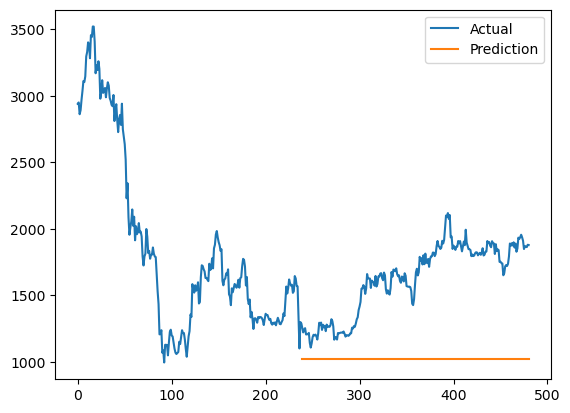

In [18]:
%env KMP_DUPLICATE_LIB_OK=TRUE

import matplotlib.pyplot as plt

%matplotlib inline

actual = []

model.eval()
with torch.no_grad():
    model.eval()
    
    prediction = []
    batch = []
    for d in original_data[2200:]:
        actual.append(d[0])
        batch.append(d)
        if len(batch) >= PRICE_INTERVAL:
            batch_t = torch.tensor([batch]).float().cuda()
            target = torch.ones(batch_t.shape[0], 1, FEATURES).cuda()
            target *= 2
            output = model(batch_t, target)
            print(output)
            prediction.append(output.cpu().item())
            batch = batch[1:]

actual = np.array(actual)
prediction = np.array(prediction)
x = np.arange(0, actual.shape[0], 1)

plt.plot(x, actual, label="Actual")
plt.plot(x[PRICE_INTERVAL-1:], prediction, label="Prediction")
plt.legend()
plt.show()

In [23]:
x = torch.randn(1, 240, 6, requires_grad=True).cuda()

history = model.init_hidden(1)

output = model(x, history)
torch.onnx.export(model,
                  (x, history),
                  "best.onnx",
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'])

# Models

In [12]:
class GruOnlyModel(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.rnn = nn.GRU(
            input_size=4,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.__num_of_layers, batch_size, self.__hidden_size).zero_()
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.shape[0]

        x, hidden = self.rnn(x, hidden)
        x = x.contiguous().view(batch_size, -1)
        
        x = self.fc(x)
        
        return (x.squeeze(), hidden)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
 
class ConvGruModel(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.conv = nn.LazyConv1d(16, 3, stride=2)
        
        self.rnn = nn.GRU(
            input_size=16,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.__num_of_layers, batch_size, self.__hidden_size).zero_()
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.shape[0]
        
        x = torch.permute(x, (0, 2, 1))
        x = self.conv(x)
        
        x = torch.permute(x, (0, 2, 1))
        x, hidden = self.rnn(x, hidden)
        x = x.contiguous().view(batch_size, -1)
        
        x = self.fc(x)
        
        return (x.squeeze(), hidden)

## MultiLayer Convolutional GRU Network

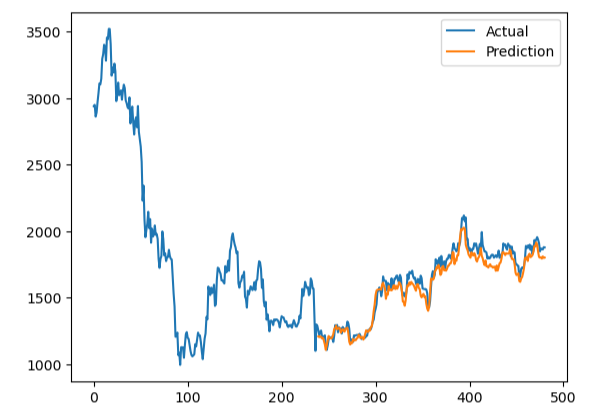

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
 
class MultiCnnGruModel(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.conv = nn.Sequential(
            nn.LazyConv1d(16, 3, stride=2),
            nn.LeakyReLU(),
            nn.LazyBatchNorm1d(),
            nn.LazyConv1d(32, 3, stride=2),
        )
        
        self.rnn = nn.GRU(
            input_size=32,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.__num_of_layers, batch_size, self.__hidden_size).zero_()
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.shape[0]
        
        x = torch.permute(x, (0, 2, 1))
        x = self.conv(x)
        
        x = torch.permute(x, (0, 2, 1))
        x, hidden = self.rnn(x, hidden)
        x = x.contiguous().view(batch_size, -1)
        
        x = self.fc(x)
        
        return (x.squeeze(), hidden)

## Multi-Convolutional 3 Layer GRU Network (MCG-3)

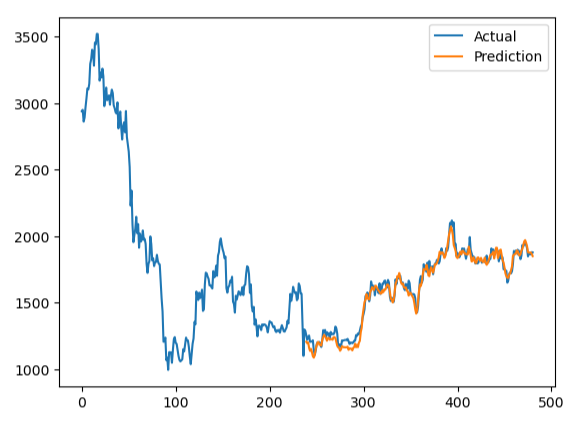

In [ ]:
class Mcg3Model(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.conv = nn.Sequential(
            nn.LazyConv1d(16, 3, stride=2),
            nn.LeakyReLU(),
            nn.LazyBatchNorm1d(),
            nn.LazyConv1d(32, 3, stride=2),
        )
        
        self.rnn = nn.GRU(
            input_size=32,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.__num_of_layers, batch_size, self.__hidden_size).zero_()
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.shape[0]
        
        x = torch.permute(x, (0, 2, 1))
        x = self.conv(x)
        
        x = torch.permute(x, (0, 2, 1))
        x, hidden = self.rnn(x, hidden)
        x = x.contiguous().view(batch_size, -1)
        
        x = self.fc(x)
        
        return (x.squeeze(), hidden)

In [4]:
import onnx

onnx_export